In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import collections

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tifffile

import pppc
from pppc.configs import InferenceConfigDict
from pppc.core import PtychoNNProbePositionCorrector, ProbePositionCorrectorChain
from pppc.ptychonn.model import PtychoNNModel
from pppc.io import DataFileHandle, NPZFileHandle, VirtualDataFileHandle
from pppc.position_list import ProbePositionList
from pppc.reconstructor import VirtualReconstructor
from pppc.util import class_timeit

[2024-01-04 14:58:07,725] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-01-04 14:58:07,729] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
scan_idx = 235
save_figs = False
output_dir = os.path.join('outputs', 'test{}'.format(scan_idx))
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

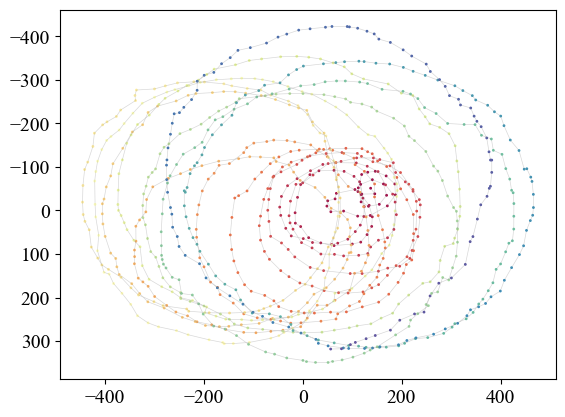

In [5]:
#psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
psize_nm = 8
probe_pos_list = ProbePositionList(file_path='data/pos{}.csv'.format(scan_idx),
                                   unit='m', psize_nm=psize_nm, convert_to_pixel=True, first_is_x=False)
fig, ax, scat = probe_pos_list.plot(show=False, return_obj=True)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_true.pdf'.format(scan_idx))
else:
    plt.show()

In [6]:
scaling_dict = collections.defaultdict(lambda: 1.0, {236: 0.5, 239: 0.5, 240: 0.25, 241: 0.25, 242: 0.25, 250: 0.5, 251: 0.5, 252: 0.25, 253: 0.25})
s = scaling_dict[scan_idx]
probe_pos_list_baseline = np.genfromtxt('data/pos221.csv', delimiter=',').astype('float32') * s  # Baseline

In [7]:
try:
    #recons = tifffile.imread('outputs/pred_test{}_model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))
    recons = tifffile.imread('outputs/pred_test{}_model_36SpiralDatasets_cleaned/pred_phase.tiff'.format(scan_idx))
    #recons = tifffile.imread('outputs/pred_test{}_model_36SpiralDatasets_TransConv/pred_phase.tiff'.format(scan_idx))
    #recons = tifffile.imread('outputs/pred_test{}_model_36SpiralDatasets_compWithTransConv_model_PtychoNNModel_nLevels_4_lossFunction_MSELoss_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))
    #recons = tifffile.imread('data/scan257_phase.tiff'.format(scan_idx))
except:
    print('Reading images from scan### folder.')
    recons = tifffile.imread('outputs/pred_scan{}_model_36SpiralDatasets_compWithTransConv_model_PtychoNNTransposedConvModel_nLevels_5_lossFunction_MSELoss_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))
#recons = tifffile.imread('data/scan{}_phase.tiff'.format(scan_idx))
config_dict = InferenceConfigDict()
#config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_cleaned/best_model.pth'
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
# config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
config_dict['dp_data_file_handle'] = VirtualDataFileHandle('', dp_shape=recons.shape[1:], num_dps=recons.shape[0])
# config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['ptycho_reconstructor'] = VirtualReconstructor(InferenceConfigDict())
config_dict['ptycho_reconstructor'].set_object_image_array(recons)
config_dict['random_seed'] = 196 
config_dict['debug'] = False
config_dict['probe_position_list'] = None
config_dict['baseline_position_list'] = ProbePositionList(position_list=probe_pos_list_baseline)

recons.shape

(961, 128, 128)

Serial correction

In [21]:
config_dict.load_from_json(os.path.join('config_jsons', 'config_{}.json'.format(scan_idx)))
config_dict

batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_cleaned/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: error_map
sift_outlier_removal_method: trial_error
sift_border_exclusion_length: 16
registration_downsample: 1
hybrid_registration_algs: ['error_map_multilevel', 'error_map_expandable', 'sift']
hybrid_registration_tols: [0.08, 0.3, 0.3]
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f67d9e65750>
probe_position_list: <pppc.position_list.ProbePositionList object at 0x7f67cf7e4490>
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
baseline_position_list: <pppc.position_list.ProbePositionList object at 0x7f67d9a7a850>
central_crop: None
method: collective
max_shift: 60
num_neighbors_collective: 6
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.001
random_seed:

In [10]:
corrector_chain = ProbePositionCorrectorChain(config_dict)
corrector_chain.build()

[2024-01-04 14:59:02,242] Now running iteration 0.
[2024-01-04 14:59:02,245] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_cleaned/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: hybrid
sift_outlier_removal_method: trial_error
sift_border_exclusion_length: 16
registration_downsample: 1
hybrid_registration_algs: ['error_map_multilevel', 'error_map_expandable', 'sift']
hybrid_registration_tols: [0.15, 0.3, 0.3]
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f67d9e65750>
probe_position_list: None
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
baseline_position_list: <pppc.position_list.ProbePositionList object at 0x7f67d9a7a850>
central_crop: None
method: serial
max_shift: 60
num_neighbors_collective: 3
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualRec

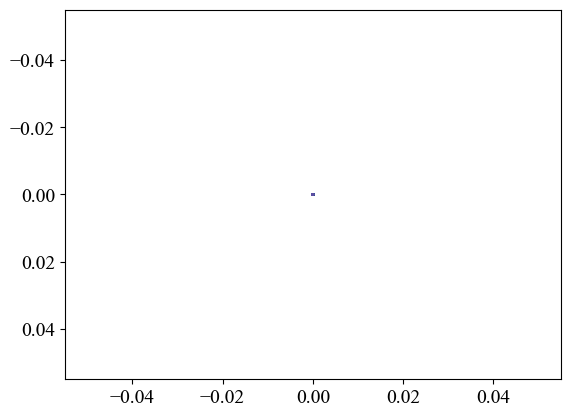

  2%|████▏                                                                                                                                                                                                                                     | 17/960 [00:00<00:44, 21.09it/s][2024-01-04 14:59:03,396] Large error after applying offset (0.18632179907370994).
[2024-01-04 14:59:03,397] Switching to error_map_expandable...
  2%|████▉                                                                                                                                                                                                                                     | 20/960 [00:01<01:16, 12.32it/s][2024-01-04 14:59:03,798] Large error after applying offset (0.1841241120208811).
[2024-01-04 14:59:03,799] Switching to error_map_expandable...
  3%|██████                                                                                                                                                          

In [11]:
corrector_chain.run_correction_iteration(0)

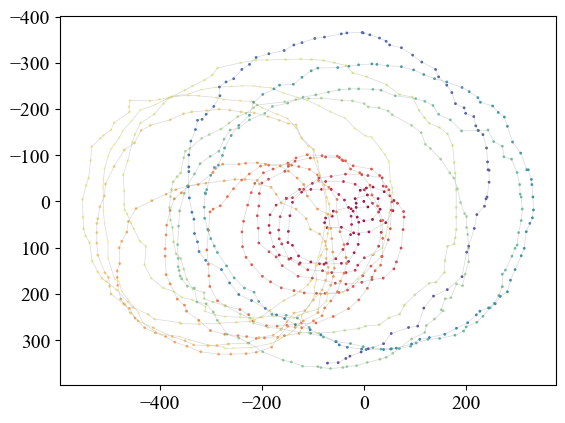

In [12]:
corrector_s = corrector_chain.corrector_list[-1]
fig, ax, scat = corrector_s.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_serial.pdf'.format(scan_idx))
else:
    plt.show()

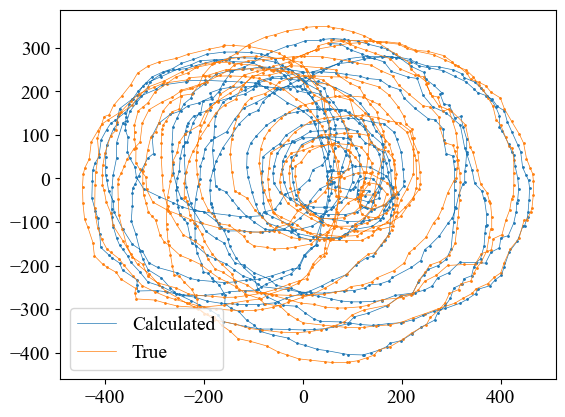

In [13]:
probe_pos_list_calc = corrector_s.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (8 * 1e-9)
probe_pos_list_calc = probe_pos_list_calc - np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true = probe_pos_list_true - np.mean(probe_pos_list_true, axis=0)
#probe_pos_list_calc = probe_pos_list_calc * 1.02
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()

[2024-01-04 15:35:43,273] Now running iteration 1.
[2024-01-04 15:35:43,275] Using result from the last iteration to initialize probe position array...
[2024-01-04 15:35:43,276] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_cleaned/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: hybrid
sift_outlier_removal_method: trial_error
sift_border_exclusion_length: 16
registration_downsample: 1
hybrid_registration_algs: ['error_map_multilevel', 'error_map_expandable', 'sift']
hybrid_registration_tols: [0.08, 0.3, 0.3]
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f67d9e65750>
probe_position_list: <pppc.position_list.ProbePositionList object at 0x7f67783c8f90>
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
baseline_position_list: <pppc.position_list.ProbePositionList object at 0x7f67d9a7a850>
central_crop: None
method: collective
max_shift: 60
num_neighbors_collective: 8
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.001
random_seed: 19

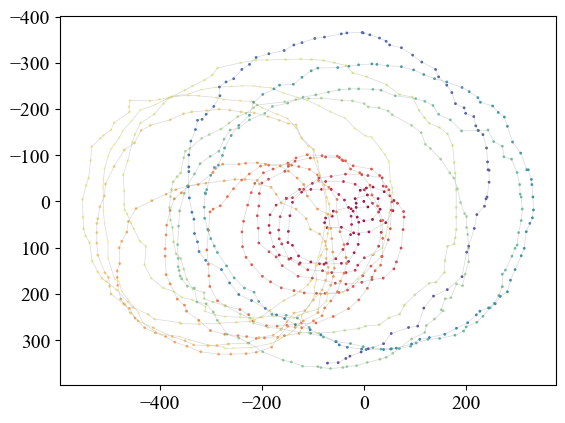

  0%|                                                                                                                                                                                                                                                   | 0/961 [00:00<?, ?it/s][2024-01-04 15:35:43,620] Large error after applying offset (0.08839016078664493).
[2024-01-04 15:35:43,622] Switching to error_map_expandable...
[2024-01-04 15:35:43,943] Large error after applying offset (0.09875752163566986).
[2024-01-04 15:35:43,945] Switching to error_map_expandable...
[2024-01-04 15:35:44,381] Large error after applying offset (0.7359772097012979).
[2024-01-04 15:35:44,382] Switching to error_map_expandable...
[2024-01-04 15:35:44,696] Result failed quality check, so I am increasing max shift to 40. (offset = [ 20. -25.], min_error = 0.8832452069838713)
[2024-01-04 15:35:45,185] Result failed quality check, so I am increasing max shift to 50. (offset = [  3. -40.], min_error = 0.7786276404193034)

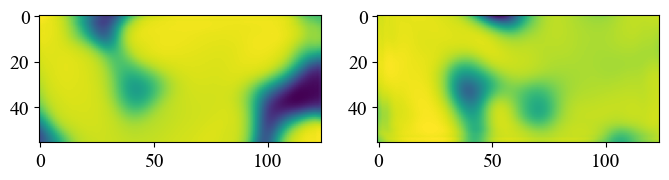

[2024-01-04 15:41:03,287] Large error after applying offset (0.403429160292551).
 16%|█████████████████████████████████████                                                                                                                                                                                                    | 153/961 [05:19<26:58,  2.00s/it][2024-01-04 15:41:03,330] Large error after applying offset (0.09725442262801279).
[2024-01-04 15:41:03,331] Switching to error_map_expandable...


0.17925
[-72   4]


[2024-01-04 15:41:03,654] Large error after applying offset (0.2889017051691685).
[2024-01-04 15:41:03,656] Switching to error_map_expandable...
[2024-01-04 15:41:03,977] Large error after applying offset (0.3535690751259473).
[2024-01-04 15:41:03,978] Switching to error_map_expandable...
[2024-01-04 15:41:04,244] Result failed quality check, so I am increasing max shift to 40. (offset = [30. 30.], min_error = 0.4098016931611952)
[2024-01-04 15:41:04,749] Large error after applying offset (0.5404763384342034).
[2024-01-04 15:41:04,750] Switching to error_map_expandable...
[2024-01-04 15:41:05,025] Large error after applying offset (0.5092447651505486).
[2024-01-04 15:41:05,026] Switching to sift...
[2024-01-04 15:41:05,075] Large error after applying offset (0.4932595130970776).
[2024-01-04 15:41:05,111] Large error after applying offset (0.22216885878196438).
[2024-01-04 15:41:05,112] Switching to error_map_expandable...
[2024-01-04 15:41:05,386] Large error after applying offset (0.5

In [ ]:
corrector_chain.run_correction_iteration(1)

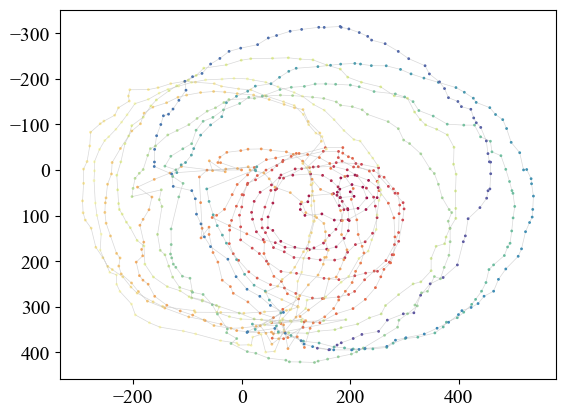

In [30]:
corrector_c1 = corrector_chain.corrector_list[1]
fig, ax, scat = corrector_c1.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_1_nn_12_sw_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

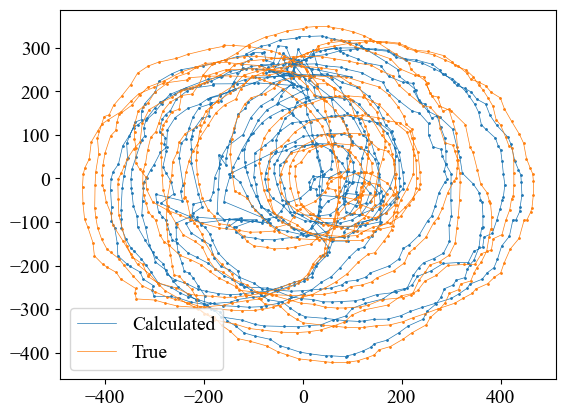

In [31]:
probe_pos_list_calc = corrector_c1.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (8 * 1e-9)
# probe_pos_list_calc = probe_pos_list_calc - probe_pos_list_calc[0]
# probe_pos_list_true = probe_pos_list_true - probe_pos_list_true[0]
probe_pos_list_calc = probe_pos_list_calc - probe_pos_list_calc.mean()
probe_pos_list_true = probe_pos_list_true - probe_pos_list_true.mean()
# probe_pos_list_calc = probe_pos_list_calc * 1.02
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()
# plt.ylim([-200, 200])
# plt.xlim([-200, 200])

In [238]:
corrector_chain.run_correction_iteration(2)

[2024-01-04 11:47:02,520] Now running iteration 2.


IndexError: list index out of range

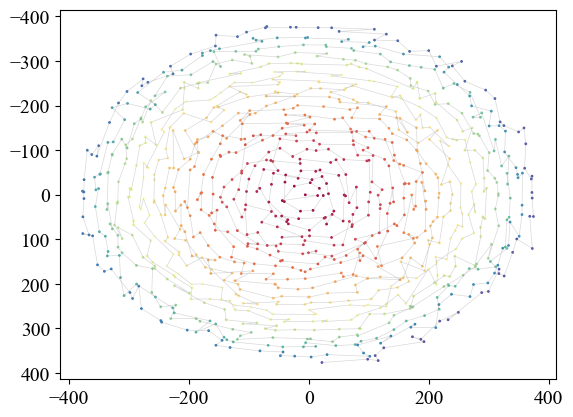

In [35]:
corrector_c2 = corrector_chain.corrector_list[2]
#corrector_c2 = corrector
fig, ax, scat = corrector_c2.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

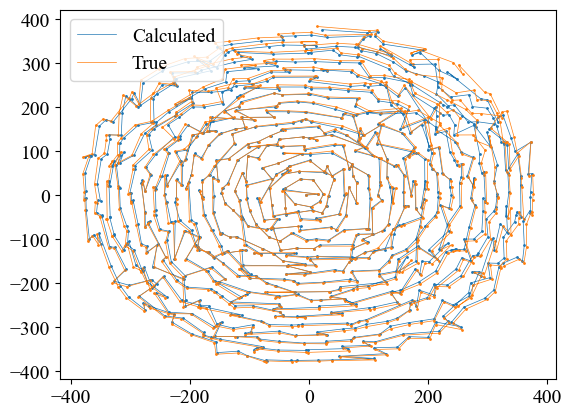

In [36]:
probe_pos_list_calc = corrector_c2.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (8 * 1e-9)
probe_pos_list_calc = probe_pos_list_calc - np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true = probe_pos_list_true - np.mean(probe_pos_list_true, axis=0)
# probe_pos_list_calc = probe_pos_list_calc * 1.04
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()
if save_figs:
    plt.savefig('outputs/test{}/comparison_path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
else:
    plt.show()

In [37]:
if save_figs:
    corrector_c2.new_probe_positions.to_csv(os.path.join(output_dir, 'calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx)), psize_nm=psize_nm)